In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
import sklearn.model_selection as sms
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
import smogn
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
import random
from scipy import ndimage
from util import pyvis
from util import extract
from loader import data_loader
from IPython.display import HTML
import util
import smogn
from smogn.phi import phi
from smogn.phi_ctrl_pts import phi_ctrl_pts
import warnings
from multiprocessing import Pool
import sklearn.linear_model as skl
import sklearn.neural_network as snn

In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

In [4]:
# X_train,X_test,y_train,y_test,train_index,test_index = util.set_split(X_all_c,per_change,1,0.1)
# X0_tt,scaler = util.make_feature_matrix(X_train,pre_updrs_off[train_index])
# n = 10
# def loop(j):
#         # Reload training data
#         X_smogn1,y_smogn1 = util.rad_smogn(X0_tt,
#                                                   y_train,
#                                                   np.min(y_train),
#                                                   np.mean(y_train),
#                                                   1,0,0.5,0.02)
#         return np.hstack((X_smogn1,y_smogn1.reshape(len(y_smogn1),1)))
# pool = Pool(os.cpu_count())
# packet = [*zip(np.arange(n))]
# results = pool.map(loop,np.arange(n))


In [5]:
# X_train_aug = np.vstack((X0_tt,(np.asarray(results)[:,:,:-1]).
#                          reshape(np.asarray(results).shape[0]*np.asarray(results).shape[1],
#                                         (np.asarray(results).shape[2]-1))))
# y_train_aug = np.hstack((y_train.ravel(),
#                          (np.asarray(results)[:,:,-1]).
#                          reshape(np.asarray(results).shape[0]*np.asarray(results).shape[1])))
# X_train_aug = X_train_aug[y_train_aug>0,:]
# y_train_aug = y_train_aug[y_train_aug>0]

In [6]:
X_train,X_test,y_train,y_test,train_index,test_index = util.set_split(X_all_c,per_change,1,0.1)
X0_tt,scaler = util.make_feature_matrix(X_train,pre_updrs_off[train_index])
entropy0 = util.calc_entropy(X0_tt.ravel())

In [8]:
X_smogn1,y_smogn1 = util.rad_smogn(X0_tt,
                                                  y_train,
                                                  np.max(y_train),
                                                  np.mean(y_train),
                                                  1,0,0.5,0.02)
X_smogn2,y_smogn2 = util.rad_smogn(X0_tt,
                                                  y_train,
                                                  np.min(y_train),
                                                  np.mean(y_train),
                                                  1,0,0.5,0.05)
X_smogn3,y_smogn3 = util.rad_smogn(X0_tt,
                                                  y_train,
                                                  np.min(y_train),
                                                  np.mean(y_train),
                                                  1,0,0.5,0.075)
X_smogn4,y_smogn4 = util.rad_smogn(X0_tt,
                                                  y_train,
                                                  np.min(y_train),
                                                  np.mean(y_train),
                                                  1,0,0.5,0.1)

# X_smogn5,y_smogn5 = util.rad_smogn(X0_tt,
#                                                   y_train,
#                                                   np.max(y_train),
#                                                   np.mean(y_train),
#                                                   1,0,0.5,0.02)


X_train_aug = np.vstack((X0_tt,X_smogn1,X_smogn2,X_smogn3,X_smogn4))
entropy_aug = util.calc_entropy(X_train_aug.ravel())
print('Entropy of augmented features is',str(entropy_aug),'and of entropy original features is',str(entropy0))
y_train_aug = np.hstack((y_train.ravel(),y_smogn1.ravel(),y_smogn2.ravel(),
                         y_smogn3.ravel(),y_smogn4.ravel()))
X_train_aug = X_train_aug[y_train_aug>0,:]
y_train_aug = y_train_aug[y_train_aug>0]


Prior to SMOGN sampling, mean is 1.28684640352781e-16 standard deviation is 0.959551639241436


r_index: 100%|##########| 3/3 [00:03<00:00,  1.28s/it]


(33, 9576)
After SMOGN sampling, mean is 0.022941272463135102 standard deviation is 0.90123060210145
After rescaling, SMOGN mean is 0.022941272463135102 standard deviation is 0.90123060210145
Prior to SMOGN sampling, mean is 1.28684640352781e-16 standard deviation is 0.959551639241436


r_index: 100%|##########| 3/3 [00:03<00:00,  1.26s/it]


(36, 9576)
After SMOGN sampling, mean is 0.08437751416892639 standard deviation is 0.7624007830855452
After rescaling, SMOGN mean is 0.08437751416892639 standard deviation is 0.7624007830855452
Prior to SMOGN sampling, mean is 1.28684640352781e-16 standard deviation is 0.959551639241436


r_index: 100%|##########| 3/3 [00:03<00:00,  1.28s/it]


(36, 9576)
After SMOGN sampling, mean is 0.08926035047660369 standard deviation is 0.7736628970234279
After rescaling, SMOGN mean is 0.08926035047660369 standard deviation is 0.7736628970234279
Prior to SMOGN sampling, mean is 1.28684640352781e-16 standard deviation is 0.959551639241436


r_index: 100%|##########| 3/3 [00:03<00:00,  1.27s/it]


(36, 9576)
After SMOGN sampling, mean is 0.09243924621197114 standard deviation is 0.8175653142520445
After rescaling, SMOGN mean is 0.09243924621197114 standard deviation is 0.8175653142520445
Entropy of augmented features is 15.638765416825805 and of entropy original features is 17.138118956127148


In [9]:
scaler00 = StandardScaler()
X_train_aug = scaler00.fit_transform(X_train_aug)

In [10]:
# mlpr = snn.MLPRegressor(max_iter=5000,verbose=True)

# param_list = {"hidden_layer_sizes": [(X_train.shape[0],X_train.shape[1],X_train.shape[2])],
#               "activation": ["identity", "logistic", "tanh", "relu"], 
#               "solver": ["lgbfs","sgd", "adam"], 
#               "alpha": [1e-1,1e-2,1e-3]}
# gridCV = sms.GridSearchCV(estimator=mlpr,param_grid=param_list,n_jobs=8,return_train_score=True)

# splits = KFold(n_splits=5)

# #plt.figure(1)
# index = 1

# for train_index, test_index in splits.split(X_train_aug):

#     training_set = X_train_aug[train_index]
#     testing_set = X_train_aug[test_index]

#     train_index_array = train_index.reshape(-1,1)
#     test_index_array = test_index.reshape(-1,1)

#     gridCV.fit(training_set,y_train_aug[train_index])
#     predicted = gridCV.predict(testing_set)
#     print('Prediction',str(predicted),'with actual',str(y_train_aug[test_index]))
#     parameters = mlpr.get_params()
#     lrr = linregress(predicted,y_train_aug[test_index])
#     print(lrr.rvalue)
#     # plt.subplot(310 + index)
#     # plt.plot(predicted)
#     # plt.plot([None for i in training_set] + [x for x in testing_set])
#     index += 1

#     train_index.flatten() 
#     test_index.flatten() 

In [54]:
# Predict

#X_train_in = scaler.fit_transform(X_train_aug)
reg_l = snn.MLPRegressor(hidden_layer_sizes=(X_train.shape[0],X_train.shape[1],X_train.shape[2]),
                         activation='relu',
                         max_iter=1000,
                        # learning_rate_init = 1e-4,
                        # learning_rate = 'invscaling',
                        #  beta_1=0.9,
                        #  beta_2=0.999,
                         tol=1e-6,
                         solver='adam',
                         epsilon=1e-1,
                         alpha=0.9,
                         verbose=True,
                         n_iter_no_change=700,
                         early_stopping=True,
                         random_state=1,
                         warm_start=True,
                         batch_size=7).fit(X_train_aug,y_train_aug)

# from sklearn.model_selection import cross_val_score
# cross_val_score(reg_l,X_train_aug,y_train_aug)

X_test_in = util.scale_feature_matrix(X_test,pre_updrs_off[test_index],scaler)
ut_l = reg_l.predict(X_test_in.reshape(X_test_in.shape[0],X_test_in.shape[1]*X_test_in.shape[2]))
lr_pred_qr = linregress(np.asarray(ut_l).ravel(),y_test)
print('Predicted improvement of ',ut_l, 'with true improvement', y_test)
lr = linregress(np.asarray(ut_l).ravel(),y_test)
lr.rvalue
# pool = Pool(os.cpu_count())
# packet = [*zip(np.arange(n))]
# results = pool.map(loop,np.arange(n))

Iteration 1, loss = 7.39827063
Validation score: -6.221487
Iteration 2, loss = 7.32507336
Validation score: -3.781475
Iteration 3, loss = 7.22975024
Validation score: -1.808895
Iteration 4, loss = 7.13533331
Validation score: -0.549015
Iteration 5, loss = 7.04501939
Validation score: -0.187987
Iteration 6, loss = 6.96762963
Validation score: -0.261380
Iteration 7, loss = 6.89827401
Validation score: -0.237155
Iteration 8, loss = 6.83497760
Validation score: -0.332942
Iteration 9, loss = 6.77636181
Validation score: -0.417616
Iteration 10, loss = 6.72139912
Validation score: -0.525237
Iteration 11, loss = 6.66353979
Validation score: -0.620827
Iteration 12, loss = 6.60788132
Validation score: -0.808146
Iteration 13, loss = 6.54923488
Validation score: -0.880263
Iteration 14, loss = 6.49154142
Validation score: -1.091275
Iteration 15, loss = 6.43390956
Validation score: -1.358051
Iteration 16, loss = 6.37267940
Validation score: -1.284697
Iteration 17, loss = 6.31051774
Validation score:

0.9112609053320916

In [2]:
# np.save('X_test_in.npy',X_test_in)
# np.save('X_train_aug.npy',X_train_aug)
# np.save('y_train_aug.npy',y_train_aug)

<function matplotlib.pyplot.show(*args, **kw)>

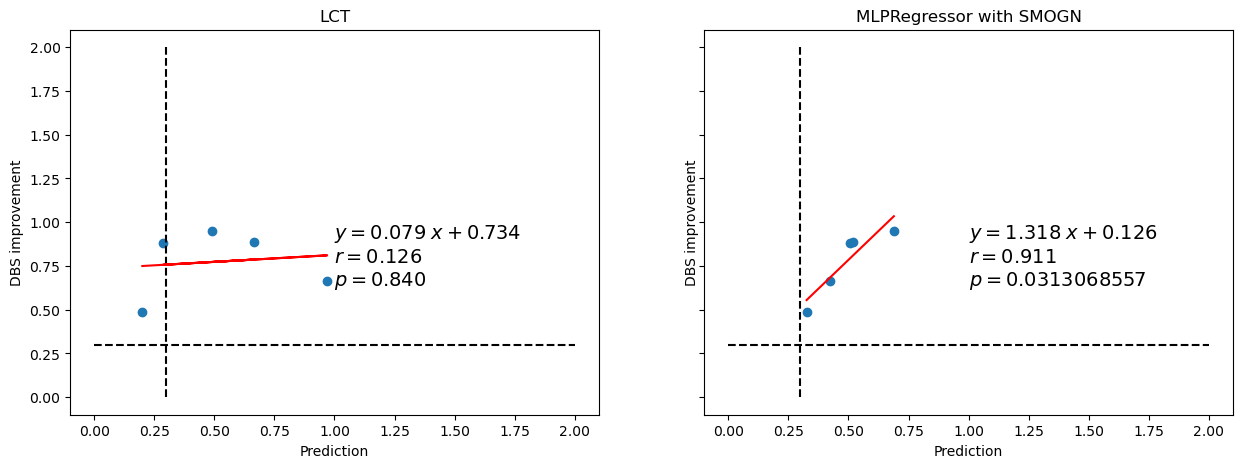

In [63]:
n = X_test.shape[0]
results = ut_l
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
# Cross validation results
[fig,ax] = plt.subplots(1,2,sharex=True, sharey=True)
lr_prepost = linregress(pre_imp[test_index],y_test)
ax[0].scatter(pre_imp[test_index],y_test)
ax[0].plot(pre_imp[test_index],pre_imp[test_index]*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
# ax[0].set_ylim([0, 1])
# ax[0].set_xlim([0, 1])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.5, 0.5, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')

lr_pred_qr = linregress(np.asarray(ut_l).ravel(),y_test)
ax[1].scatter(np.asarray(ut_l).ravel(),y_test)
ax[1].plot(np.asarray(ut_l).ravel(),np.asarray(ut_l).ravel()*lr_pred_qr.slope+lr_pred_qr.intercept,'-r')
ax[1].set_title('MLPRegressor with SMOGN')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_qr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qr.rvalue:0.3f}$\n$p = {lr_pred_qr.pvalue:0.10f}$"
ax[1].text(0.5, 0.5, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')

plt.style.use('default')
plt.show

In [56]:
# n = X0_t.shape[0]
# def loop(j):
#         # Reload training data
#         X_in = X_all_c[:n,:,:]
#         per_change_in = per_change[:n]
#         pre_updrs_off_in = pre_updrs_off[:n]
#         # Delete test case
#         X_in = np.delete(X_in,j,axis=0)
#         pre_updrs_off_in = np.delete(pre_updrs_off[:n],j)
#         per_change_in = np.delete(per_change[:n],j)
#         # Concatenate pre-updrs, scale, and reshape
#         X_in_t,scaler = util.make_feature_matrix(X_in,pre_updrs_off_in)
#         reg_l = ElasticNetCV().fit(X_in_t,per_change_in)
#         # Predict
#         X_test = util.scale_feature_matrix(np.expand_dims(X_all_c[j,:,:],axis=0),pre_updrs_off[j],scaler)
#         ut_l = reg_l.predict(X_test.reshape(1, -1))
#         # ut = reg.predict(X_test.reshape(1, -1))
#         print('Predicted improvement of ',ut_l, 'with true improvement', per_change[j])
#         #print('SMOGN predicted improvement of ',ut, 'with true improvement', per_change[j])
#         return ut_l
# pool = Pool(os.cpu_count())
# packet = [*zip(np.arange(n))]
# results = pool.map(loop,np.arange(n))